In [1]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import Dataset

from transformers import AutoProcessor, Pix2StructConfig, Pix2StructForConditionalGeneration

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## CNN to Classify Graph:

In [2]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    # Check if the image is grayscale then convert to color
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img = img.resize(target_size)

    return img

In [3]:
def pil_to_tensor(img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img)

def show_image(img):
    plt.imshow(img)
    plt.axis('off')  # remove axes for visual appeal
    plt.show()

In [4]:
# image_path = '/kaggle/input/benetech-making-graphs-accessible/test/images/007a18eb4e09.jpg'
# img = preprocess_image(image_path)
# tensor = pil_to_tensor(img)
# show_image(img)

In [5]:
chart_type_list = ['dot', 'horizontal_bar', 'vertical_bar', 'line', 'scatter']
def get_chart_type(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    if data["chart-type"] in chart_type_list:
        return data["chart-type"]
    else:
        print("Invalid chart type in the JSON file. Using default chart type.")
        return chart_type_list[3]

In [6]:
# Get data points from training annotations
def get_chart_data(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    data_series = data["data-series"]
    x_preds = []
    y_preds = []

    for item in data_series:
        x_preds.append(item['x'])
        y_preds.append(item['y'])
    
    return x_preds, y_preds

In [7]:
class GraphDataset(Dataset):
    def __init__(self, image_dir, json_dir, transform=None):
        self.image_dir = image_dir
        self.json_dir = json_dir
        self.transform = transform
        
        self.image_files = os.listdir(image_dir)
        self.json_files = [f"{name.split('.')[0]}.json" for name in self.image_files]

        # assuming that chart types are 'dot', 'horizontal_bar', 'vertical_bar', 'line', 'scatter'
        self.classes = ['dot', 'horizontal_bar', 'vertical_bar', 'line', 'scatter']

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        json_file = self.json_files[idx]
        
        # Process image
        image = preprocess_image(os.path.join(self.image_dir, image_file))
        if self.transform:
            image = self.transform(image)

        # Process json
        chart_type = get_chart_type(os.path.join(self.json_dir, json_file))
        chart_data = get_chart_data(os.path.join(self.json_dir, json_file))
        # Convert chart type to an integer
        label = self.classes.index(chart_type)

        return os.path.join(self.json_dir, json_file), image, label

In [8]:
# DATA LOADER
from torch.utils.data import Subset
from torch.utils.data import random_split

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your dataset
folder_path = '/kaggle/input/benetech-making-graphs-accessible/train/images/'

# Get the list of items in the folder
items = os.listdir(folder_path)
num_samples = int(len(items)/4)
dataset = GraphDataset(folder_path, '/kaggle/input/benetech-making-graphs-accessible/train/annotations/', transform=transform)
subset = Subset(dataset, torch.arange(num_samples))
#subset = Subset(dataset, torch.arange(len(dataset)))

# Define the proportion for the split
train_proportion = 0.8  # e.g., 80% training, 20% validation
n_train = int(len(subset)*train_proportion)
n_val = len(subset) - n_train

# Perform the split
train_dataset, val_dataset = random_split(subset, [n_train, n_val])

# Create data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
# Load the pretrained model if it exists
if os.path.exists('/kaggle/input/resnet50/resnet50.bin'):
    model = torch.load('/kaggle/input/resnet50/resnet50.bin').to(device)
else:
    model = resnet50(weights='DEFAULT')
    num_features = model.fc.in_features
    num_charts = 5
    model.fc = torch.nn.Linear(num_features, num_charts)  # replace num_classes with the number of your classes

    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 10
    model = model.to(device)

    print("Starting training:")
    for epoch in range(num_epochs):
        for i, (json_file, inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


In [11]:
model.eval()  # ensure the model is in evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for json_dir, inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the validation images: {100 * correct / total}%')

Accuracy of the model on the validation images: 99.30670188180918%


In [12]:
# Save the model if it doesn't exist
# if not os.path.exists('/kaggle/working/resnet50'):
#     torch.save(model, '/kaggle/working/resnet50')

## Load DePlot Model

In [13]:
# if deplot model exists, load it
if os.path.exists('/kaggle/input/googledeplot') and os.path.exists('/kaggle/input/deplot-processor'):
    print("File Exists")
    deplot_model = Pix2StructForConditionalGeneration.from_pretrained('/kaggle/input/googledeplot').to(device)
    processor = AutoProcessor.from_pretrained("/kaggle/input/deplot-processor")
else:
    deplot_model = Pix2StructForConditionalGeneration.from_pretrained("google/deplot").to(device)
    processor = AutoProcessor.from_pretrained("google/deplot")
    # Save the model if it doesn't exist
    deplot_model.save_pretrained('/kaggle/working/deplot_model.bin')
    processor.save_pretrained('/kaggle/working/deplot_processor.bin')

File Exists


In [14]:
# Test model on an image
# image = Image.open('/kaggle/input/benetech-making-graphs-accessible/test/images/01b45b831589.jpg')
# inputs = processor(images=image, text="Generate underlying data table of the figure below:", font_path="/kaggle/input/arial-font/arial.ttf", return_tensors="pt").to(device)
# predictions = deplot_model.generate(**inputs, max_new_tokens=512)
# print(processor.decode(predictions[0], skip_special_tokens=True))
# show_image(image)

# deplot_model.save_pretrained('/kaggle/working/deplot_model.bin')
# processor.save_pretrained('/kaggle/working/deplot_processor.bin')

## Run Data-Series on Validation

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rapidfuzz.distance.Levenshtein import distance as levenshtein
from sklearn.metrics import r2_score

def sigmoid(x):
    return 2 - 2 / (1 + np.exp(-x))


def normalized_rmse(y_true, y_pred):
    # The argument to the sigmoid transform is equal to 
    # rmse(y_true, y_pred) / rmse(y_true, np.mean(y_true))
    return sigmoid((1 - r2_score(y_true, y_pred)) ** 0.5)


def normalized_levenshtein_score(y_true, y_pred):
    total_distance = np.sum([levenshtein(yt, yp) for yt, yp in zip(y_true, y_pred)])
    length_sum = np.sum([len(yt) for yt in y_true])
    return sigmoid(total_distance / length_sum)


def score_series(y_true, y_pred):
    if len(y_true) != len(y_pred):
        return 0.0
    if isinstance(y_true[0], str):
        return normalized_levenshtein_score(y_true, y_pred)
    else:
        return normalized_rmse(y_true, y_pred)


def benetech_score(ground_truth: pd.DataFrame, predictions: pd.DataFrame) -> float:
    """Evaluate predictions using the metric from the Benetech - Making Graphs Accessible.
    
    Parameters
    ----------
    ground_truth: pd.DataFrame
        Has columns `[data_series, chart_type]` and an index `id`. Values in `data_series` 
        should be either arrays of floats or arrays of strings.
    
    predictions: pd.DataFrame
    """
    if not ground_truth.index.equals(predictions.index):
        raise ValueError("Must have exactly one prediction for each ground-truth instance.")
    if not ground_truth.columns.equals(predictions.columns):
        raise ValueError(f"Predictions must have columns: {ground_truth.columns}.")
    pairs = zip(ground_truth.itertuples(index=False), predictions.itertuples(index=False))
    scores = []
    for (gt_series, gt_type), (pred_series, pred_type) in pairs:
        if gt_type != pred_type:  # Check chart_type condition
            scores.append(0.0)
        else:  # Score with RMSE or Levenshtein as appropriate
            scores.append(score_series(gt_series, pred_series))
    return np.mean(scores)

In [16]:
ground_truth = pd.DataFrame.from_dict({
    '0a0a0_x': (['abc', 'def', 'ghi'], 'vertical_bar'),
    '0a0a0_y': ([0, 1, 2], 'vertical_bar'),
    '1b1b1_x': ([101.24, 90.3, 50.51], 'scatter'),
    '1b1b1_y': ([43.81, 10.12, 11.0], 'scatter'),
}, orient='index', columns=['data_series', 'chart_type']).rename_axis('id')

predictions = pd.DataFrame.from_dict({
    '0a0a0_x': (['a', 'difd', 'ghi'], 'vertical_bar'),
    '0a0a0_y': ([0.2, 0.9, 2.1], 'vertical_bar'),
    '1b1b1_x': ([101.24, 90.3, 50.51], 'dot'),  # wrong chart_type
    '1b1b1_y': ([43.81, 10.12, 11.0, 5.4], 'scatter'),  # wrong number of values in data_series
}, orient='index', columns=['data_series', 'chart_type']).rename_axis('id')

benetech_score(ground_truth, predictions)

0.423744558683027

In [17]:
display(ground_truth)

,data_series,chart_type
id,,
0a0a0_x,"[abc, def, ghi]",vertical_bar
0a0a0_y,"[0, 1, 2]",vertical_bar
1b1b1_x,"[101.24, 90.3, 50.51]",scatter
1b1b1_y,"[43.81, 10.12, 11.0]",scatter


In [18]:
# # Create ground_truth data frame based on validation set
# val_ground_truth_data = {}

# for idx, (json_files, inputs, labels) in enumerate(val_dataloader):
#     batch_size = inputs.size(0)  # Get the batch size
    
#     for i in range(batch_size):
#         json_file = json_files[i]
#         json_filename = os.path.basename(json_file)

#         # Process json
#         chart_type = get_chart_type(json_file)
#         chart_data = get_chart_data(json_file)
#         key = json_filename[:-5]  # Remove the file extension from the json filename

#         val_ground_truth_data[key + "_x"] = (chart_data[0], chart_type)
#         val_ground_truth_data[key + "_y"] = (chart_data[1], chart_type)

# val_ground_truth = pd.DataFrame.from_dict(val_ground_truth_data, orient='index', columns=['data_series', 'chart_type']).rename_axis('id')

In [19]:
# display(val_ground_truth)

# print(val_ground_truth.index)

In [20]:
def predict_graph_type(image_path):
    # Load and preprocess the input image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

    # Move the input tensor to the device
    input_tensor = input_tensor.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_label = predicted_idx.item()

    return predicted_label

In [21]:
def is_valid_value(value):
    invalid_values = ["nan", "-inf", "inf"]
    if value.startswith("<0x"):
        return False
    elif value in invalid_values:
        return False
    else:
        return True

In [22]:
# Function to convert DePlot (predictions[0], skip_special_tokens=True) to useable data
def deplot_to_csv(data, filename, train=True):
    # Split the 'data' string into separate lines
    lines = data.split("<0x0A>")
    # print(lines)

    # Remove the first line (headers)
    header = lines[0]
    lines = lines[2:]

    # Initialize lists to store the data
    ids = []
    x_preds = ""
    y_preds = ""
    chart_types = []

    id_ = filename
    if train:
        chart_type = predict_graph_type('/kaggle/input/benetech-making-graphs-accessible/train/images/' + filename + '.jpg')
    else:
        chart_type = predict_graph_type('/kaggle/input/benetech-making-graphs-accessible/test/images/' + filename + '.jpg')

    ids.append(f"{id_}_x")
    ids.append(f"{id_}_y")
    chart_types.append(chart_type_list[chart_type])

    # Process each line to extract the required information
    x_preds = ""
    y_preds = ""
    for line in lines:
        # Skip empty lines
        if not line:
            x_preds = "0;0"
            y_preds = "0;0"
            continue

        # Split the line by '|' and remove leading/trailing whitespaces
        parts = [part.strip() for part in line.split("|")]
        
        # Skip lines where the number of parts is not equal to 2
        if len(parts) < 2:
            continue
            
        # Replace invalid values with '0'
        x_pred = parts[0] if is_valid_value(parts[0]) else '0'
        y_pred = parts[1] if is_valid_value(parts[1]) else '0'

        # Add the values to the corresponding lists
        if x_preds == "": x_preds += x_pred
        else:x_preds += ";" + x_pred

        if y_preds == "": y_preds += y_pred
        else:y_preds += ";" + y_pred
            
    if x_preds == "":
        x_preds = "0;0"
    if y_preds == "":
        y_preds = "0;0"

    return ids, x_preds, y_preds, chart_types

In [23]:
# # Create val_prediction data frame based on validation set
# val_prediction_data = {}

# for idx, (json_files, inputs, labels) in enumerate(val_dataloader):
#     batch_size = inputs.size(0)  # Get the batch size
#     print("Batch:", idx)
    
#     for i in range(batch_size):
#         json_file = json_files[i]
#         filename = os.path.basename(json_file)
#         filename_without_extension = os.path.splitext(filename)[0]
        
#         # Generate the image path by combining the image directory and the filename with the '.jpg' extension
#         image_path = os.path.join(image_dir, filename_without_extension + '.jpg')
#         print(image_path)

#         # Test model on the image
#         image = Image.open(image_path)
#         inputs = processor(images=image, text="Generate underlying data table of the figure below:", font_path="/kaggle/input/arial-font/arial.ttf", return_tensors="pt").to(device)
#         predictions = deplot_model.generate(**inputs, max_new_tokens=512)
#         data = processor.decode(predictions[0], skip_special_tokens=True)

#         # Extract the id, x_preds, y_preds, and chart_types from the deplot_to_csv function
#         key = filename[:-5]  # Remove the file extension from the json filename
#         ids, x_preds, y_preds, chart_type = deplot_to_csv(data, key, train=True)
        
#         # Convert ';' separated string to list
#         x_preds = x_preds.split(';')
#         y_preds = y_preds.split(';')

#         val_prediction_data[key + "_x"] = (x_preds, chart_type)
#         val_prediction_data[key + "_y"] = (y_preds, chart_type)

In [24]:
# val_prediction = pd.DataFrame.from_dict(val_prediction_data, orient='index', columns=['data_series', 'chart_type']).rename_axis('id')
# val_prediction.index.name = 'id'

In [25]:
# display(val_prediction)
# print(val_prediction.index)

In [26]:
# print("Benetech_score : ",benetech_score(val_ground_truth, val_prediction))

## Generate submission

In [27]:
# filename = 'c72ab56084d2.jpg'
# test_folder = "/kaggle/input/benetech-making-graphs-accessible/train/images/"
# # Create an empty DataFrame to store the results
# all_sub_df = pd.DataFrame(columns=["id", "data_series", "chart_type"])
# # Check if the file is an image
# if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
#     # Construct the image path
#     image_path = os.path.join(test_folder, filename)

#     # Test model on the image
#     image = Image.open(image_path)
#     inputs = processor(images=image, text="Generate underlying data table of the figure below:", font_path="/kaggle/input/arial-font/arial.ttf", return_tensors="pt").to(device)
#     predictions = deplot_model.generate(**inputs, max_new_tokens=512)
#     data = processor.decode(predictions[0], skip_special_tokens=True)

#     # Extract the id, x_preds, y_preds, and chart_types from the deplot_to_csv function
#     file_id = os.path.splitext(filename)[0]
#     ids, x_preds, y_preds, chart_types = deplot_to_csv(data, file_id, train=True)

#     # Create the DataFrame for the current image
#     sub_df = pd.DataFrame(
#         data={
#             "id": ids,
#             "data_series": [x_preds, y_preds],
#             "chart_type": chart_types * 2,
#         }
#     )
#     # View df for current img
#     show_image(image)
#     display(sub_df)

#     # Append the current DataFrame to the overall DataFrame
#     all_sub_df = pd.concat([all_sub_df, sub_df])
    
# display(all_sub_df)

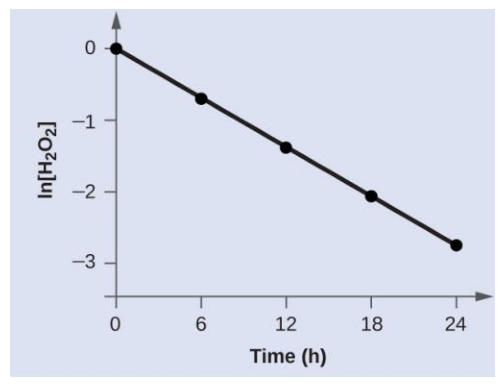

,id,data_series,chart_type
0,000b92c3b098_x,0;6;12;18;24,line
1,000b92c3b098_y,0;1.32;2.62;1.94;-3.25,line


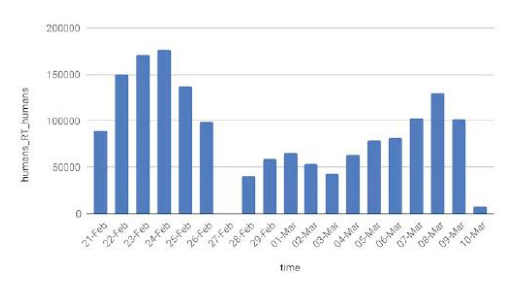

,id,data_series,chart_type
0,01b45b831589_x,21-Feb;22-Feb;23-Feb;24-Feb;25-Feb;26-Feb;27-F...,vertical_bar
1,01b45b831589_y,89000;151192;172700;177800;137500;99168;17242;...,vertical_bar


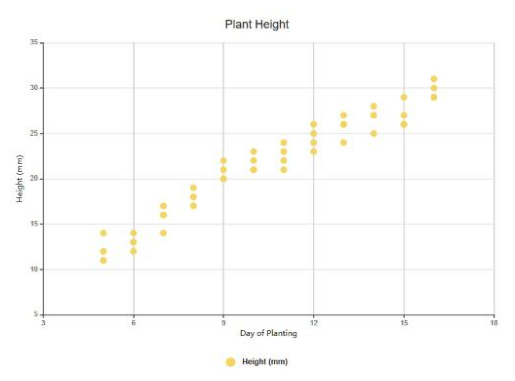

,id,data_series,chart_type
0,00f5404753cf_x,3;4;5;6;7;8;9;10,scatter
1,00f5404753cf_y,14;13.8;22;26;25.9;27;22;23.0,scatter


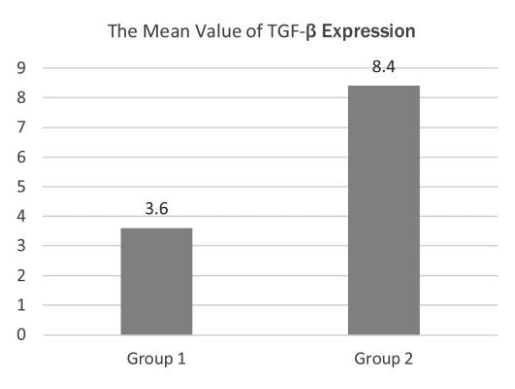

,id,data_series,chart_type
0,00dcf883a459_x,Group 1;Group 2,vertical_bar
1,00dcf883a459_y,3.6;8.4,vertical_bar


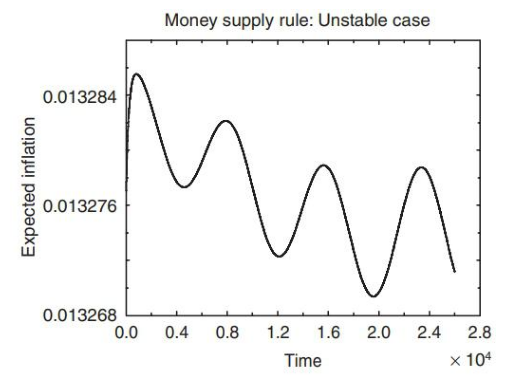

,id,data_series,chart_type
0,007a18eb4e09_x,2013;2014;2015;2016;2017;2018;2019;2020;2021;2...,line
1,007a18eb4e09_y,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...,line


In [28]:
# Directory path for the test images
test_folder = "/kaggle/input/benetech-making-graphs-accessible/test/images/"

# Create an empty DataFrame to store the results
all_sub_df = pd.DataFrame(columns=["id", "data_series", "chart_type"])

# Iterate through the test folder and process each image
for filename in os.listdir(test_folder):
    # Check if the file is an image
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # Construct the image path
        image_path = os.path.join(test_folder, filename)

        # Test model on the image
        image = Image.open(image_path)
        inputs = processor(images=image, text="Generate underlying data table of the figure below:", font_path="/kaggle/input/arial-font/arial.ttf", return_tensors="pt").to(device)
        predictions = deplot_model.generate(**inputs, max_new_tokens=512)
        data = processor.decode(predictions[0], skip_special_tokens=True)

        # Extract the id, x_preds, y_preds, and chart_types from the deplot_to_csv function
        file_id = os.path.splitext(filename)[0]
        ids, x_preds, y_preds, chart_types = deplot_to_csv(data, file_id, train=False)

        # Create the DataFrame for the current image
        sub_df = pd.DataFrame(
            data={
                "id": ids,
                "data_series": [x_preds, y_preds],
                "chart_type": chart_types * 2,
            }
        )
        # View df for current img
        show_image(image)
        display(sub_df)

        # Append the current DataFrame to the overall DataFrame
        all_sub_df = pd.concat([all_sub_df, sub_df], ignore_index=True)

In [29]:
# Create a DataFrame with column names as the first row
header_row = pd.DataFrame(columns=all_sub_df.columns)
all_sub_df = pd.concat([header_row, all_sub_df], ignore_index=True)

# Save the overall DataFrame to a CSV file
output_path = '/kaggle/working/submission.csv'
all_sub_df.to_csv(output_path, index=False)

In [30]:
display(all_sub_df)
# print((all_sub_df["data_series"][9]))
# print(type(all_sub_df["id"][0]))
# print(type(all_sub_df["chart_type"][0]))

,id,data_series,chart_type
0,000b92c3b098_x,0;6;12;18;24,line
1,000b92c3b098_y,0;1.32;2.62;1.94;-3.25,line
2,01b45b831589_x,21-Feb;22-Feb;23-Feb;24-Feb;25-Feb;26-Feb;27-F...,vertical_bar
3,01b45b831589_y,89000;151192;172700;177800;137500;99168;17242;...,vertical_bar
4,00f5404753cf_x,3;4;5;6;7;8;9;10,scatter
5,00f5404753cf_y,14;13.8;22;26;25.9;27;22;23.0,scatter
6,00dcf883a459_x,Group 1;Group 2,vertical_bar
7,00dcf883a459_y,3.6;8.4,vertical_bar
8,007a18eb4e09_x,2013;2014;2015;2016;2017;2018;2019;2020;2021;2...,line
9,007a18eb4e09_y,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...,line


In [31]:
# Read the CSV file into a Pandas DataFrame
# dataframe = pd.read_csv('/kaggle/input/benetech-making-graphs-accessible/sample_submission.csv')

# # Display the DataFrame
# print(dataframe)
# # print(dataframe["id"])
# print(type(all_sub_df["id"][0]))
# print(type(dataframe["data_series"][0]))
# print(type(dataframe["chart_type"][0]))